In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import math

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
df_train = pd.read_hdf('../data/EC15_split.h5', key="train")
df_valid = pd.read_hdf('../data/EC15_split.h5', key="validation")
df_test = pd.read_hdf('../data/EC15_split.h5', key="test")

df_train = pd.concat([df_train, df_valid])
df_train.sort_index(inplace=True)

interesting_cols = df_train.columns[df_train.columns.str.endswith('24')]

## Feature engineering

In [3]:
def log_returns(series_prices):
    return np.log(series_prices).diff()

def trend(series):
    return (series[-1] - series[0]) / len(series)

def diff(series):
    return (series[-1] - series[0])

def diff_max(series):
    return np.max(series - series[0])

def diff_min(series):
    return np.min(series - series[0])

def diff_mean(series):
    return np.mean(series - series[0])

def geo_difference(df):
    df = df.copy()
    countries = ["FRA", "NLD", "GBR", "ESP", "DEU", "FIN", "ITA"]
    
    n_cols = []
    for s_col in df.columns:
        s_cty = s_col[s_col.find("-")+1:s_col.find("-")+4]
        for a_cty in countries:
            if a_cty != s_cty:
                a_col = s_col.replace(s_cty, a_cty)
                if a_col in df.columns:
                    n_cols.append(pd.Series(np.subtract(df[s_col],df[a_col]), name=s_col+"_minus_"+a_col))
    df = pd.concat([df] + n_cols, axis=1)
    return df

def preprocess_data(df, cols):
    df = df[cols].copy()
    
    last_days = [4]
    for period in tqdm(last_days):
        for col in cols:
            for fn in []:
                new_col_name = col + "_" + fn.__name__ + '_' + str(period)
                new_col = df[col].rolling(period).apply(fn, engine='numba', raw=True)
                df[new_col_name] = new_col
    
    return df

## Training & evaluation pipeline

In [4]:
def add_y(data, target_name, td):
    data['y'] = data[target_name].shift(-td)
    return data.drop('y', axis=1), data['y']

In [5]:
def data_split(data, target_name, td):
    from sklearn.model_selection import train_test_split
    data.sort_index(inplace=True)
    data['y'] = data[target_name].shift(-td)
    X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.05, shuffle=False, random_state=1)
    
    return np.array(data.index[:len(X_train)]), X_train, y_train, X_test, y_test

In [6]:
def train_lightgbm(X_train, y_train):
    import lightgbm as lgb
    
    model = lgb.LGBMRegressor(n_jobs=-1, force_col_wise=True, verbosity=0)
    model.fit(X_train, y_train)
    
    return model

In [7]:
def r2_calc(y_train, y, y_hat):
    sse = np.sum((y - y_hat)**2)
    sst = np.sum((y - y_train.mean())**2)
    return 1 - sse/sst

def train_and_predict_lightgbm(X_train, y_train, X_valid, y_valid):
    model = train_lightgbm(X_train, y_train)
    
    y_hat = model.predict(X_valid)
    y = np.array(y_valid)
    
    indexes = np.array(~np.isnan(y) & ~np.isnan(y_hat))
    y = y[indexes]
    y_hat = y_hat[indexes]
    
    return y, y_hat, model

def evaluate_lightgbm(X_train, y_train, X_valid, y_valid, td, plot=False, plt_title=''):
    y, y_hat, model = train_and_predict_lightgbm(X_train, y_train, X_valid, y_valid)
    
    mae = np.abs(np.array(y)-np.array(y_hat))
    mae = mae[~np.isnan(mae)].mean()
    mse = np.square(np.array(y)-np.array(y_hat))
    mse = mse[~np.isnan(mse)].mean()
    
    from sklearn.metrics import r2_score
    r2 = r2_calc(y_train, y, y_hat)
    
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(3, 1, figsize=(18, 12))
        x_axis = pd.to_datetime(X_valid.index[-len(y):])
        sns.lineplot(x=x_axis, y=y, label='Value', ax=ax[0])
        sns.lineplot(x=x_axis, y=y_hat, label='Predicted value', alpha=0.5, ax=ax[0])
        ax[0].set_title(plt_title)
        
        sns.scatterplot(x=y, y=y_hat-y, ax=ax[1])
        
        lgb.plot_importance(model, max_num_features=10, ax=ax[2])
    
    return r2, mae, mse, model

In [53]:
def winkler_score(y_model_0, y_std, y_true, stds):
    from scipy.stats import norm
    l = y_model_0 - stds * y_std
    u = y_model_0 + stds * y_std
    α = norm.cdf(l, loc=y_model_0, scale=y_std) * 2
    
    if y_true < l:
        return (u - l) + 2/α * (l - y_true)
    elif y_true > u:
        return (u - l) + 2/α * (y_true - u)
    else:
        return (u - l)
    
def evaluate_impact(y_hat_model_0, y_hat_std, y_forecast_model_0, y_forecast_std, y_true, stds):
        assert len(y_hat_model_0) == len(y_hat_std), "Lengths should be same"
        assert len(y_hat_std) == len(y_forecast_model_0), "Lengths should be same"
        assert len(y_forecast_model_0) == len(y_forecast_std), "Lengths should be same"
        assert len(y_forecast_std) == len(y_true), "Lengths should be same"
        
        winkler_hat = []
        winkler_forecast = []
        for i in range(len(y_hat_model_0)):
            winkler_hat.append(winkler_score(y_hat_model_0[i], y_hat_std[i], y_true[i], stds))
            if sum(np.isnan(winkler_hat)):
                print(f"NAn: {y_hat_model_0[i]}, {y_hat_std[i]}, {y_true[i]}")
            winkler_forecast.append(winkler_score(y_forecast_model_0[i], y_forecast_std[i], y_true[i], stds))
            if sum(np.isnan(winkler_hat)):
                print(f"NAn f: {y_hat_model_0[i]}, {y_hat_std[i]}, {y_true[i]}")
            
        return np.array(winkler_hat), np.array(winkler_forecast)

In [56]:
def evaluate_impact_lightgbm(region_metric, forecast_horizon, td, stds, plot=False):
    target_name = 'model_0_value-' + region_metric + '-' + str(forecast_horizon)
    forecast_name = 'model_0_value-' + region_metric + '-' + str(forecast_horizon + td * 12)
    
    df_train_processed = geo_difference(df_train)
    X_train, y_train = add_y(df_train_processed, target_name, td)
    df_valid_processed = geo_difference(df_valid)
    X_valid, y_valid = add_y(df_valid_processed, target_name, td)
    y_hat_true_model_0, y_hat_model_0, _ = train_and_predict_lightgbm(X_train, y_train, X_valid, y_valid)
    y_forecast_model_0 = X_valid[forecast_name].iloc[:-td]
    
    df_results = pd.DataFrame({"y_hat_model_0": y_hat_model_0,
                               "y_forecast_model_0": y_forecast_model_0})
    
    target_name = 'ens_std-' + region_metric + '-' + str(forecast_horizon)
    forecast_name = 'ens_std-' + region_metric + '-' + str(forecast_horizon + td * 12)
    df_train_processed = geo_difference(df_train)
    X_train, y_train = add_y(df_train_processed, target_name, td)
    df_valid_processed = geo_difference(df_valid)
    X_valid, y_valid = add_y(df_valid_processed, target_name, td)
    y_hat_true_std, y_hat_std, _ = train_and_predict_lightgbm(X_train, y_train, X_valid, y_valid)
    y_forecast_std = X_valid[forecast_name].iloc[:-td]
    
    df_results["y_hat_std"] = y_hat_std
    df_results["y_forecast_std"] = y_forecast_std
    
    df_results["true"] = X_train['model_0_value-' + region_metric + '-0'].shift(-4)
    
    winkler_hat, winkler_forecast = evaluate_impact(df_results["y_hat_model_0"], df_results["y_hat_std"], df_results["y_forecast_model_0"], df_results["y_forecast_std"], df_results["true"], stds)
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
        x_axis = pd.to_datetime(X_valid.index[-len(winkler_forecast):])
        sns.lineplot(x=x_axis, y=winkler_forecast, label='Winkler forecast', ax=ax)
        sns.lineplot(x=x_axis, y=winkler_hat, label='Winkler predicted', alpha=0.75, ax=ax)
    
    return (winkler_forecast.mean() - winkler_hat.mean()) / winkler_forecast.mean() * 100

## LightGBM impact in termms of Winkler returns

In [71]:
region_metrics = df_train.columns.str.replace("model_0_value-", "").str.replace("ens_std-", "").str[:13].unique()
improvements = []

from tqdm import tqdm
for region_metric in tqdm(region_metrics):
    improvements.append(evaluate_impact_lightgbm(region_metric, 24, 2, 1))
df_impact = pd.DataFrame({"region_metric": region_metrics, "winkler_improvement": improvements})

100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.13s/it]


In [78]:
df_impact

,region_metric,winkler_improvement
0,FRA_WIND_EC15,12.563452
1,NLD_WIND_EC15,14.766979
2,GBR_WIND_EC15,5.245645
3,DEU_WIND_EC15,7.959604
4,FRA_TEMP_EC15,1.841407
5,GBR_TEMP_EC15,5.245645
6,DEU_TEMP_EC15,3.658664


## LightGBM performance for ens_std-DEU_TEMP_EC15-24

Series mean: 0.33989487779429467
Series std: 0.13521167575899584
R2: 0.8741885815715666
MAE: 0.03971999596172652
MSE: 0.00259147365402406


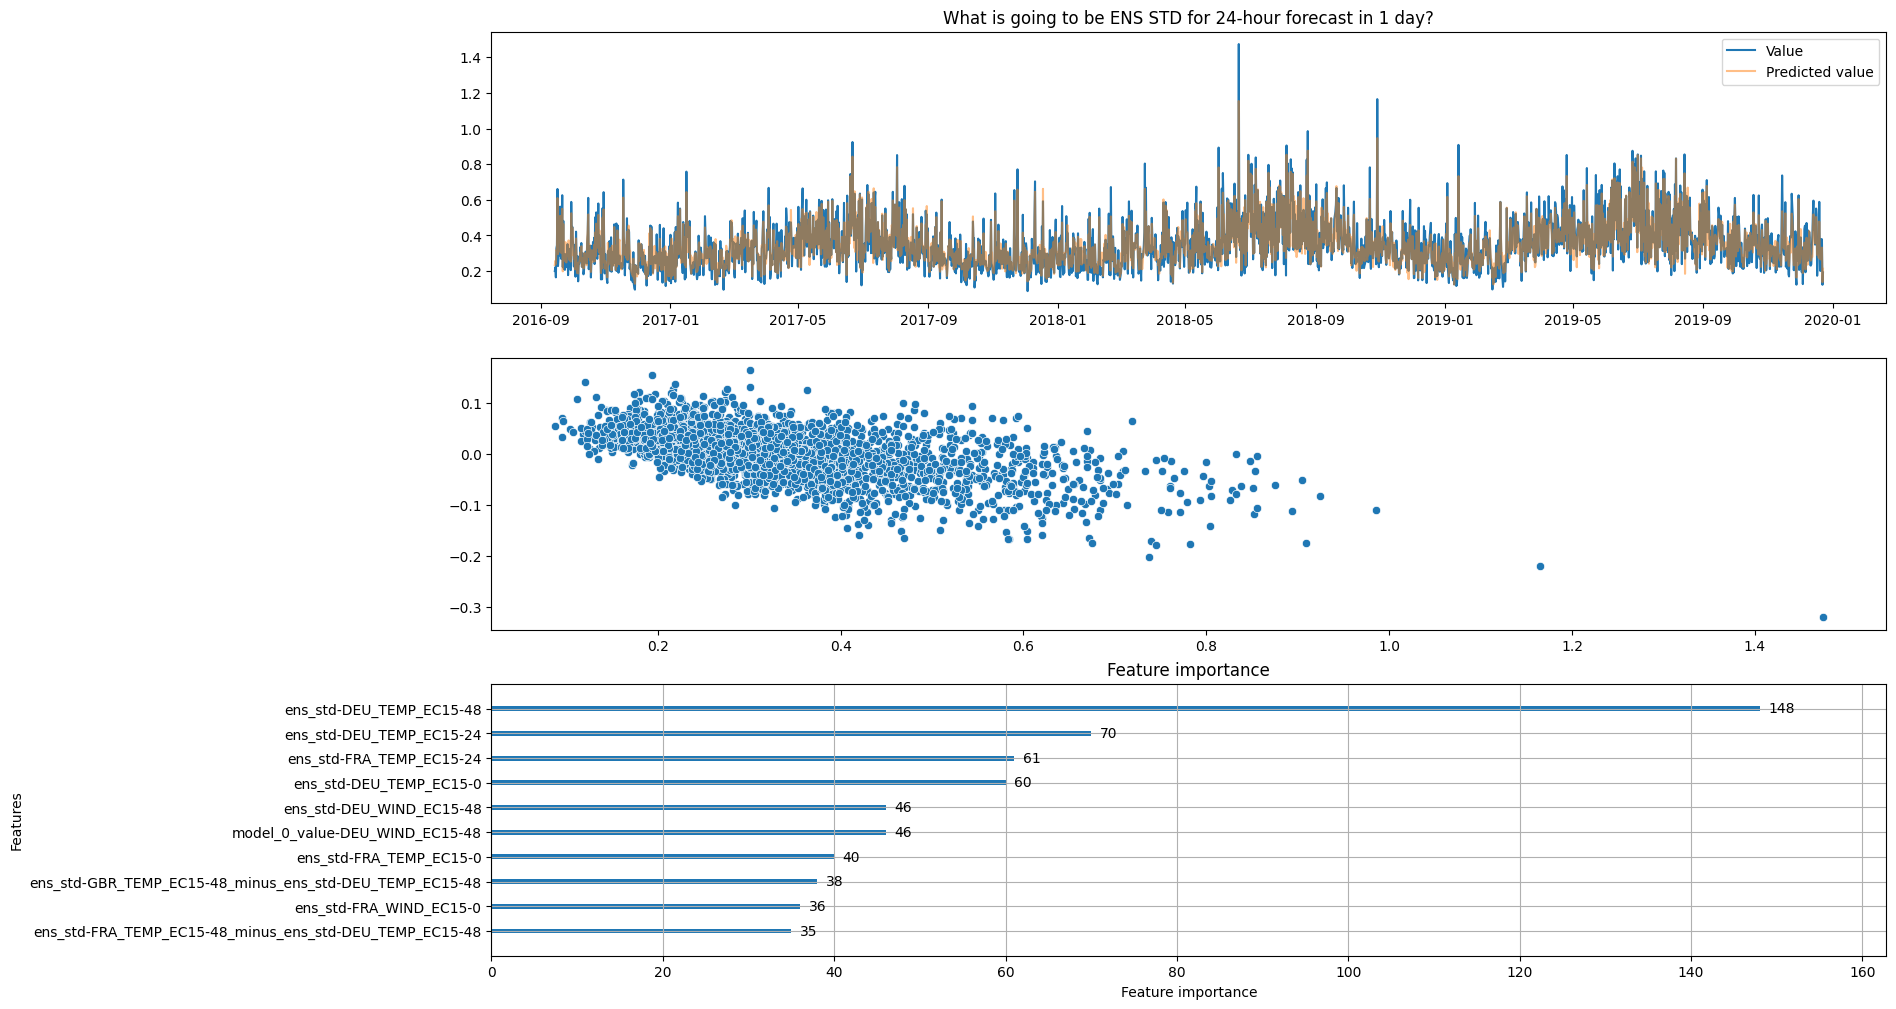

In [153]:
td = 2
forecast_horizon = 24
target_name = 'ens_std-DEU_TEMP_EC15-' + str(forecast_horizon)
forecast_name = 'ens_std-DEU_TEMP_EC15-' + str(forecast_horizon + td * 12)

df_train_processed = geo_difference(df_train)
X_train, y_train = add_y(df_train_processed, target_name, td)

df_valid_processed = geo_difference(df_valid)
X_valid, y_valid = add_y(df_valid_processed, target_name, td)

r2, mae, mse, model = evaluate_lightgbm(X_train, y_train, X_valid, y_valid, td, True, 'What is going to be ENS STD for ' + str(forecast_horizon) + '-hour forecast in 1 day?')    

print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

## Overall LightGBM performance

In [10]:
data = {
    'target': [],
    'r2': [],
    'mae': [],
    'mse': []
}

df_train_processed = geo_difference(df_train)
df_valid_processed = geo_difference(df_valid)

for col in tqdm(interesting_cols):
    X_train, y_train = add_y(df_train_processed, col, 2)
    X_valid, y_valid = add_y(df_valid_processed, col, 2)
    
    r2, mae, mse, model = evaluate_lightgbm(X_train, y_train, X_valid, y_valid, 2)
    
    data['target'].append(col)
    data['r2'].append(r2)
    data['mae'].append(mae)
    data['mse'].append(mse)
df_results = pd.DataFrame.from_dict(data)

100%|███████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


In [11]:
df_results

,target,r2,mae,mse
0,model_0_value-FRA_WIND_EC15-24,0.985710,0.133181,0.029869
1,ens_std-FRA_WIND_EC15-24,0.898067,0.021545,0.000788
2,model_0_value-NLD_WIND_EC15-24,0.966512,0.293014,0.150727
3,ens_std-NLD_WIND_EC15-24,0.875209,0.054217,0.005138
4,model_0_value-GBR_WIND_EC15-24,0.996796,0.234207,0.093897
5,ens_std-GBR_WIND_EC15-24,0.851895,0.039045,0.002566
6,model_0_value-DEU_WIND_EC15-24,0.977541,0.168379,0.048892
7,ens_std-DEU_WIND_EC15-24,0.888551,0.027388,0.001274
8,model_0_value-FRA_TEMP_EC15-24,0.997753,0.266800,0.121075
9,ens_std-FRA_TEMP_EC15-24,0.825793,0.042281,0.002916
